In [4]:
library(ggplot2)
library(RColorBrewer)
library(dplyr)
library(tibble)
library(patchwork)
library(Seurat)
library(magrittr)
library(scuttle)
library(circlize)
library(tidyr)
library(ComplexHeatmap)
library(magick)

Linking to ImageMagick 7.1.1.38
Enabled features: cairo, fontconfig, freetype, fftw, heic, rsvg, webp, x11
Disabled features: ghostscript, lcms, pango, raw



In [5]:
custom_colors <- list()

colors_dutch <- c("#16a085", "#2980b9", "#4834d4", "#f39c12", "#c0392b",
                  "#130f40", "#f78fb3", "#65d6ce", "#d1c145", "#2ecc71",
                  "#d35400", "#c44569", '#ff7f50', '#706fd3', '#f9ca24',
                  '#34ace0', '#33d9b2', '#2c2c54', '#be2edd')

colors_spanish <- c(
  '#40407a','#706fd3','#f7f1e3','#34ace0','#33d9b2',
  '#2c2c54','#474787','#aaa69d','#227093','#218c74',
  '#ff5252','#ff793f','#d1ccc0','#ffb142','#ffda79',
  '#b33939','#cd6133','#84817a','#cc8e35','#ccae62'
)

custom_colors$discrete <- c(colors_dutch, colors_spanish)

custom_colors$cell_cycle <- setNames(
  c('#45aaf2', '#f1c40f', '#e74c3c', '#7f8c8d'),
  c('G1',      'S',       'G2M',     '-')
)

In [6]:
options(repr.plot.width = 18, repr.plot.height = 17, repr.plot.pointsize = 24)

chargement des données

In [7]:
embryo_mutli_species <- readRDS("/home/adufour/work/rds_storage/omics/stemcell_multi_species_obj_v4.rds")

In [8]:
embryo_mutli_species <- FindClusters(embryo_mutli_species, resolution = 0.2)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 35699
Number of edges: 1255705

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9742
Number of communities: 18
Elapsed time: 9 seconds


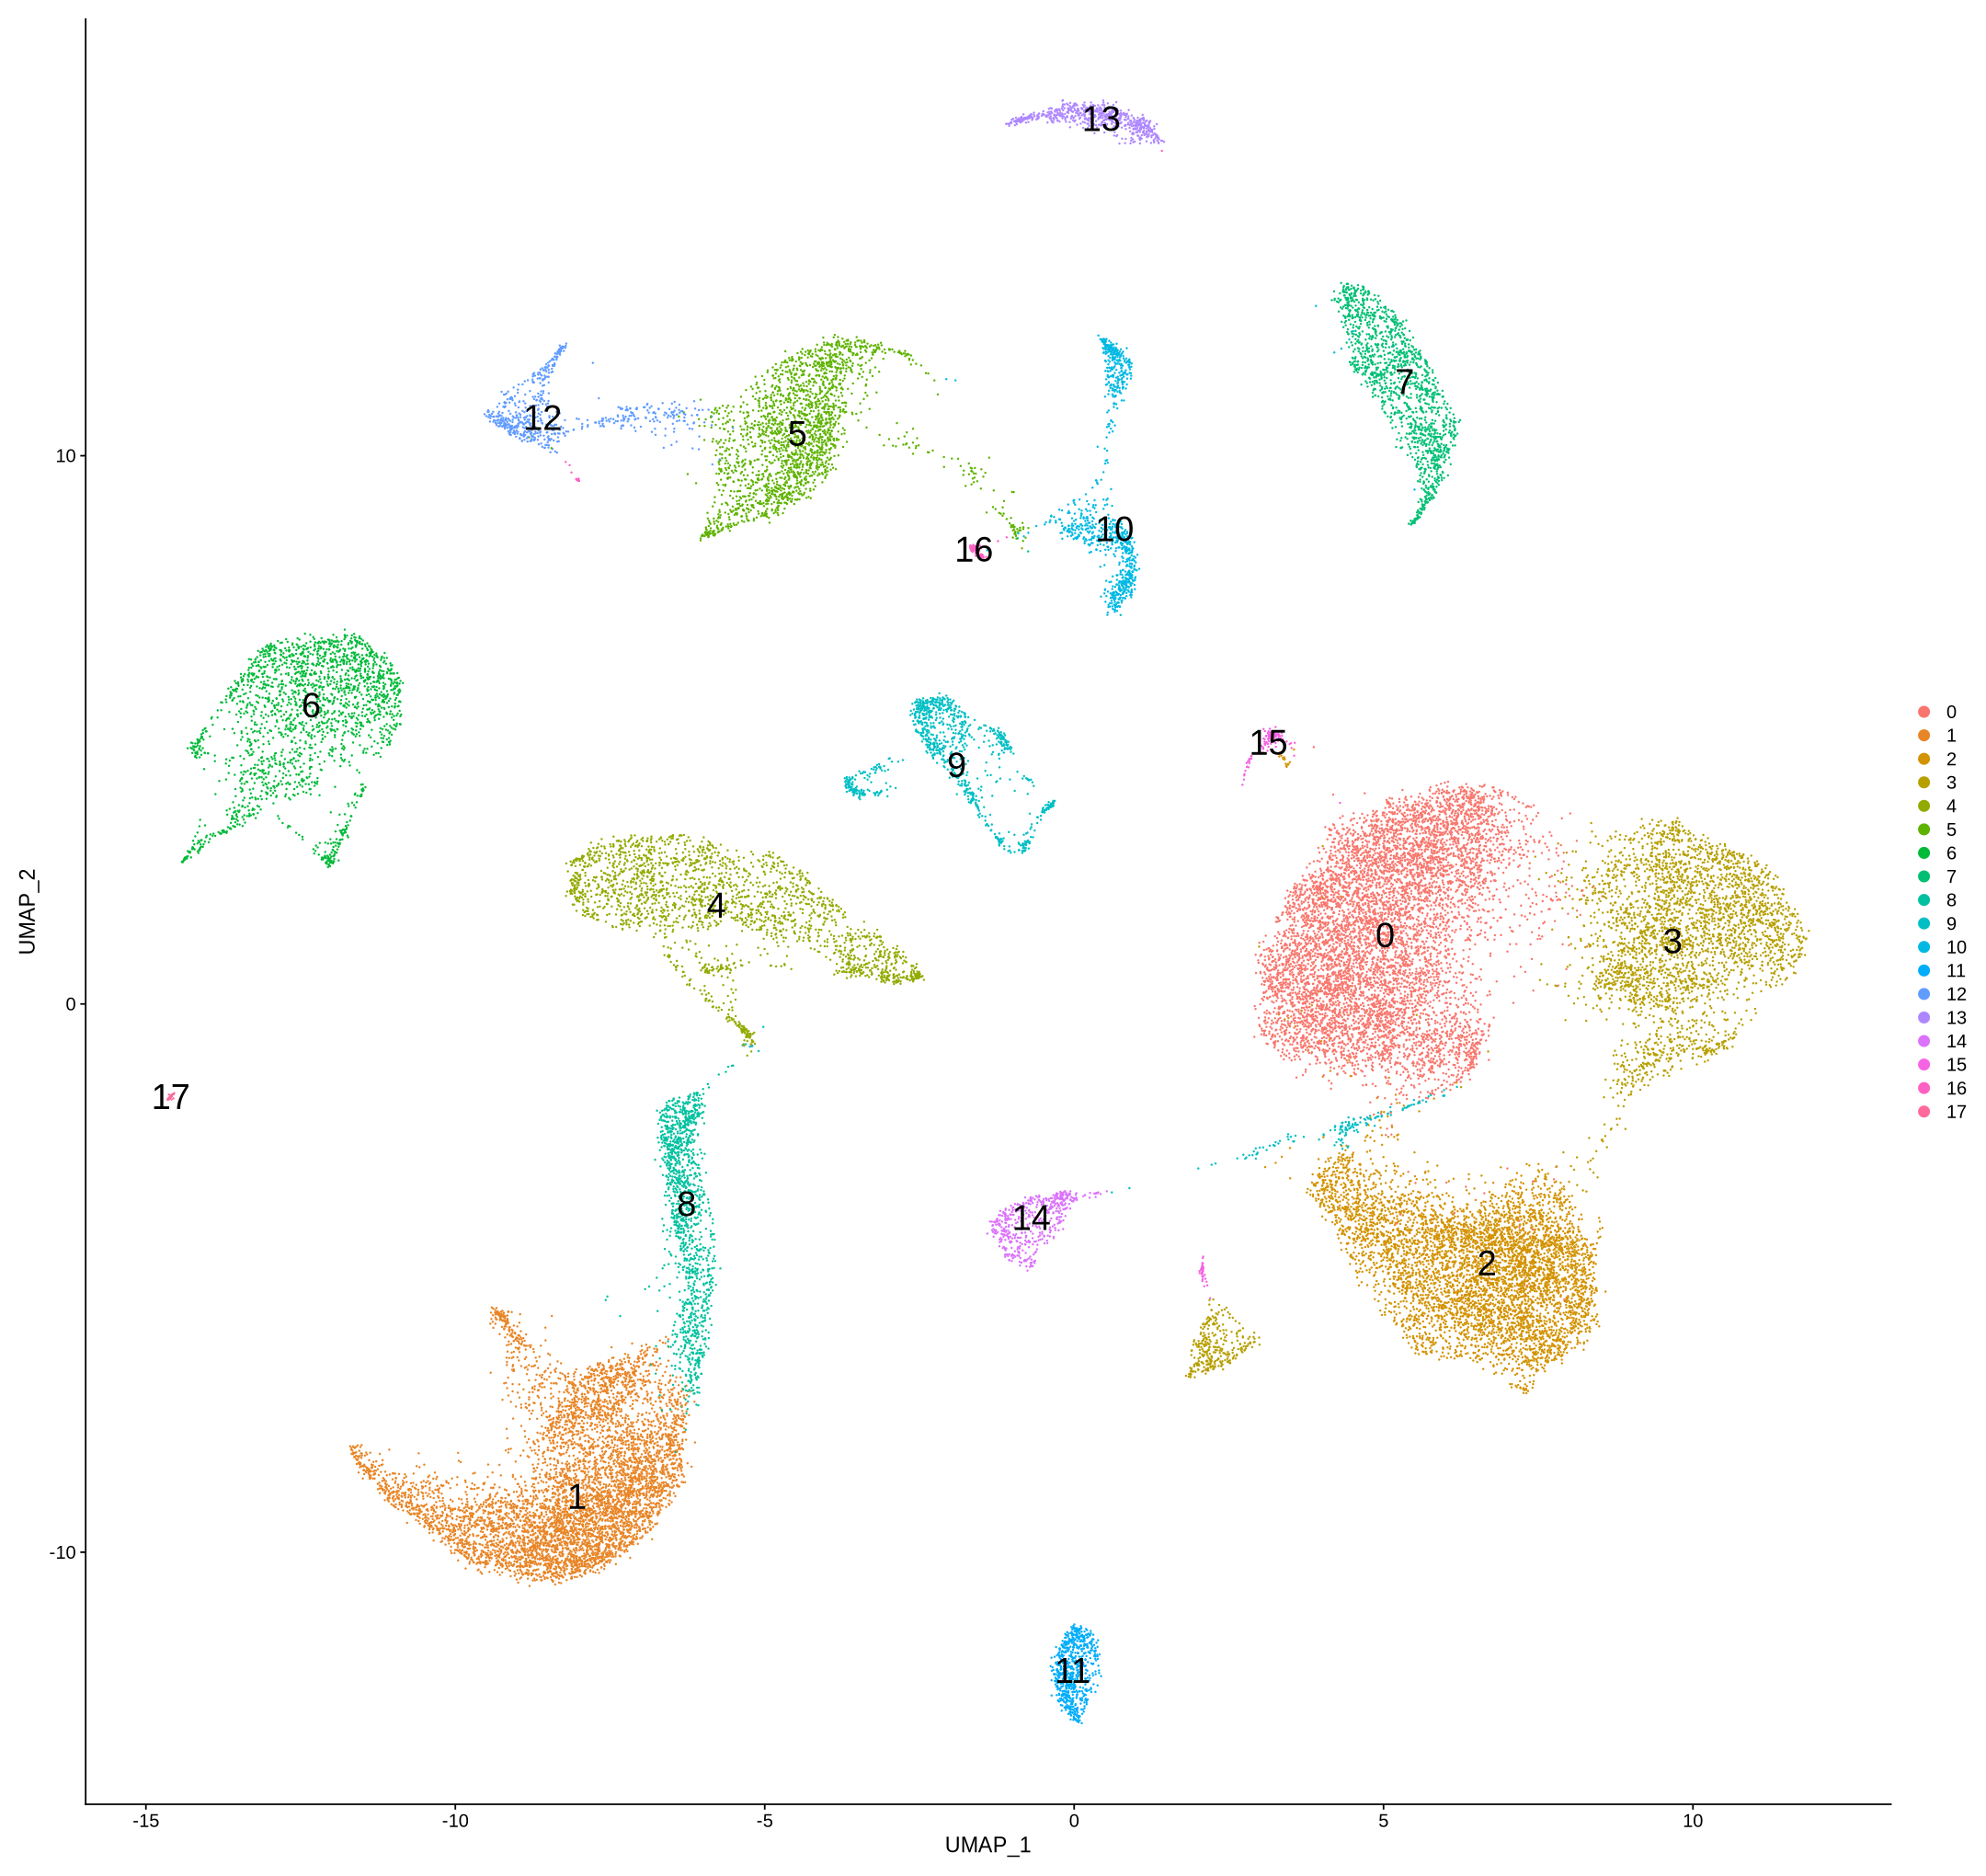

In [9]:
DimPlot(embryo_mutli_species, reduction = "umap", label = TRUE, label.size = 8)

In [10]:
Idents(embryo_mutli_species) <- "seurat_clusters"

In [11]:
embryo_mutli_species@meta.data$neo_cluster <- embryo_mutli_species@meta.data$seurat_clusters

In [12]:
embryo_mutli_species@meta.data[embryo_mutli_species@meta.data$species == "C6",]$species <- "Pig"
embryo_mutli_species@meta.data[embryo_mutli_species@meta.data$species == "C4",]$species <- "Pig"
embryo_mutli_species@meta.data[embryo_mutli_species@meta.data$species == "C2",]$species <- "Pig"
embryo_mutli_species@meta.data[embryo_mutli_species@meta.data$species == "human_naive",]$species <- "Human"
embryo_mutli_species@meta.data[embryo_mutli_species@meta.data$species == "human_primed",]$species <- "Human"
embryo_mutli_species@meta.data[embryo_mutli_species@meta.data$species == "human_primed_nownt",]$species <- "Human"

In [13]:
embryo_mutli_species@meta.data[embryo_mutli_species@meta.data$seurat_clusters == "2",]$seurat_clusters <- "0"
embryo_mutli_species@meta.data[embryo_mutli_species@meta.data$seurat_clusters == "12",]$seurat_clusters <- "0"
embryo_mutli_species@meta.data[embryo_mutli_species@meta.data$seurat_clusters == "5",]$seurat_clusters <- "3"

In [15]:
Idents(embryo_mutli_species) <- "seurat_clusters"

In [17]:
clusterconserv.markers <- FindConservedMarkers(embryo_mutli_species, ident.1 = "3", ident.2 = "0", grouping.var = "species")

Warning message:
“Identity: 3 not present in group Sheep. Skipping Sheep”
Warning message:
“Identity: 3 not present in group bos taurus. Skipping bos taurus”
Warning message:
“Identity: 3 not present in group mus musculus. Skipping mus musculus”
Testing group Human: (3) vs (0)

Testing group Pig: (3) vs (0)



In [19]:
positiv_marker <- clusterconserv.markers[clusterconserv.markers$Human_avg_log2FC > 0 & clusterconserv.markers$Pig_avg_log2FC > 0,]

In [20]:
markers_pos <- positiv_marker %>%
    slice_max(n = 20, order_by = Human_avg_log2FC)

In [21]:
negative_marker <- clusterconserv.markers[clusterconserv.markers$Human_avg_log2FC < 0 & clusterconserv.markers$Pig_avg_log2FC < 0,]

In [22]:
markers_neg <- negative_marker %>%
    slice_min(n = 20, order_by = Human_avg_log2FC)

In [23]:
gene_list <- c("CDH2", "ZEB1", "DPYSL5", "VIM", "SSBP2", "MAP1B", "TTC28", "FHOD3",
               "GRIK2", "CCDC88A", "ROBO1", "PLCH1", "CD9", "EPCAM", "RBM47", "CLDN7",
               "ESRP1", "GRHL2", "MYO1D", "SPINT1", "SPINT2", "PATJ", 
               "HSPB1", "RABGAP1L")

In [24]:
counts <- GetAssayData(embryo_mutli_species, assay="RNA", slot="data")
average_expression_profiles_by_cluster <- as.matrix(counts[rownames(counts) %in% gene_list, ])

Warning message:
“The `slot` argument of `GetAssayData()` is deprecated as of SeuratObject 5.0.0.
ℹ Please use the `layer` argument instead.”


In [25]:
Idents(embryo_mutli_species) <- "neo_cluster"

In [26]:
embryo_subset <- subset(x = embryo_mutli_species, idents = c("12", "5", "0", "3"))

In [27]:
embryo_subset$type <- 0

In [28]:
embryo_subset@meta.data[sample(rownames(embryo_subset@meta.data[embryo_subset@meta.data$neo_cluster == "12",]), 630),]$type <- 1
embryo_subset@meta.data[sample(rownames(embryo_subset@meta.data[embryo_subset@meta.data$neo_cluster == "5",]), 1000),]$type <- 1
embryo_subset@meta.data[sample(rownames(embryo_subset@meta.data[embryo_subset@meta.data$neo_cluster == "0",]), 1000),]$type <- 1
embryo_subset@meta.data[sample(rownames(embryo_subset@meta.data[embryo_subset@meta.data$neo_cluster == "3",]), 1000),]$type <- 1

In [29]:
Idents(embryo_subset) <- "type"
embryo_subset <- subset(x = embryo_subset, idents = "1")

In [30]:
groups.use <- embryo_subset[['neo_cluster']][, , drop = FALSE]

In [31]:
groups.use$cells <- rownames(groups.use)

In [32]:
groups.use[groups.use$neo_cluster == "5",]$neo_cluster <- "1"
groups.use[groups.use$neo_cluster == "3",]$neo_cluster <- "2"
groups.use[groups.use$neo_cluster == "12",]$neo_cluster <- "3"
groups.use[groups.use$neo_cluster == "0",]$neo_cluster <- "4"

In [33]:
#groups.use <- groups.use[runif(2000, min=1, max=20277),]
groups.use <- groups.use[order(groups.use$neo_cluster),]
cell_order <- groups.use$cells

In [30]:
mat <- MinMax(as.matrix(average_expression_profiles_by_cluster[,cell_order]), -2.5, 2.5)
col_fun <- colorRamp2(seq(min(mat), max(mat), length = 100), colorRampPalette(rev(brewer.pal(n = 10, name = "RdYlBu")))(100))
hb <- HeatmapAnnotation(foo = anno_block(gp = gpar(fill = c("#00a085","#1a7fb6","#4a2ed0","#f79c30")),
                                                   labels = c('1', '2', '3', '4'),
                                         labels_gp = gpar(col = c("black", "black", "white", "black", "white", "white", "black", "black"), fontsize = 18)))
lgd <- list(title = "Expression levels", legend_height = unit(6, "cm"), grid_width = unit(1, "cm"), labels_gp = gpar(fontsize = 20), title_gp = gpar(fontsize = 18), title_position = "leftcenter-rot")

In [31]:
split = c(rep(1, as.list(table(groups.use$neo_cluster))$`1`),
rep(2, as.list(table(groups.use$neo_cluster))$`2`),
rep(3, as.list(table(groups.use$neo_cluster))$`3`),
rep(4, as.list(table(groups.use$neo_cluster))$`4`))

In [33]:
options(repr.plot.width=50, repr.plot.height=50) # To set the figure size in Jupyter
library(svglite)
svg('/home/adufour/work/notebook/plots/gene_heatmap_top20_matrice_data.svg',width=19,height=40)
hm <- draw(ComplexHeatmap::Heatmap(mat,
                                   col = col_fun,
                                   cluster_columns = FALSE,
                                   #cluster_rows = FALSE,
                                   row_names_gp=grid::gpar(fontface = "italic", fontsize=24),
                                   show_column_names = FALSE,
                                   top_annotation = hb,
                                   column_split = split,
                                   column_title = NULL,
                                   heatmap_legend_param = lgd), padding = unit(c(2, 2, 2, 10), "mm"))
hm
dev.off()

`use_raster` is automatically set to TRUE for a matrix with more than
2000 columns You can control `use_raster` argument by explicitly
setting TRUE/FALSE to it.

Set `ht_opt$message = FALSE` to turn off this message.



png 
  2

In [35]:
library(openxlsx)

In [46]:
write.xlsx(rbind(positiv_marker, negative_marker), file = "/home/adufour/work/table/conserved_marker_human_pig.xlsx", rowNames = TRUE)